# Data exploration

## Author

- Kamwoo Lee (klee16@worldbank.org)

## Contents

1. [Reuired packages](#required_packages)
2. [Data](#data)
    - 2.1. Folders and layers in ArcGIS geodatabase
    - 2.2. Layer summaries
    - 2.3. Field summaries
    - 2.4. Controlled vocabulary
3. [Visualizations](#visualizations)


# 1. Required packages <a name="required_packages"></a>

The required packages should be installed AFTER cloning arcgispro-py3 which is a conda environment that comes with ArcGIS Pro.
* arcgispro-py3 (including arcpy) is dependent on python=3.6
* many recent packages require python>3.7, so we have to use older versions

In [1]:
import os
from os import listdir
import re
import pandas as pd # v1.0.3 (latest v1.4.1)
import numpy as np # v1.18.1 (latest v1.21.5)
import json
import geojson
import geopandas as gpd # v0.6.3 (latest v0.10.2)
import fiona # v1.8.4 (latest v1.8.21)
import rasterio # v1.0.21 (latest v1.2.10)
from rasterio.plot import show
from shapely.geometry import shape, GeometryCollection
from shapely.wkt import loads
import arcpy # v2.6
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import matplotlib # v3.2.1 (latest v3.5.1)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import seaborn as sns
from tqdm.notebook import tqdm

# 2. Data <a name="data"></a>


In [2]:
DATA_DIR = "DRC_CPF/"
RESULT_DIR = "02_CPF_DRC_data_exploration/"
FILE_NAME = "drc_cpf.gdb"
arcpy.env.workspace = DATA_DIR + FILE_NAME

## 2.1. Folders and layers in ArcGIS geodatabase

* Codes for listing up individual types

```python
datasets = arcpy.ListDatasets()
for dataset in datasets:
    print(arcpy.Describe(dataset).baseName, f"[{arcpy.Describe(dataset).dataType}]")
    for child in arcpy.Describe(dataset).children:
        print("\t", child.baseName, f"[{child.dataType}]")
```

```python
feature_classes = arcpy.ListFeatureClasses()
for feature_class in feature_classes:
    print(arcpy.Describe(feature_class).baseName, f"[{arcpy.Describe(feature_class).dataType}]")
```

```python
rasters = arcpy.ListRasters()
for raster in rasters:
    print(arcpy.Describe(raster).baseName, f"[{arcpy.Describe(raster).dataType}]")
```

```python
tables = arcpy.ListTables()
for table in tables:
    print(arcpy.Describe(table).baseName, f"[{arcpy.Describe(table).dataType}]")
```


* Traverse a directory tree

In [3]:
walk = arcpy.da.Walk(arcpy.env.workspace, topdown=False)
layers = pd.DataFrame(columns = ['dir', 'name', 'data_type'])
for dir_path, dir_names, data_names in walk:
    dir_name = re.sub(r'^.*' + FILE_NAME, "", dir_path)
    dir_name = re.sub(r'^\\', "", dir_name)
    for data_name in data_names:
        data_type = arcpy.Describe(data_name).dataType
        layers.loc[len(layers)] = [dir_name, data_name, data_type]
        
layers

,dir,name,data_type
0,,DRC_grid,FeatureClass
1,,COD_ADM1_WSF_Summary,Table
2,,COD_CITY_WSF_Summary,Table
3,,location__1_2021_01_28_16_08,Table
4,,PDSS_facilities,Table
...,...,...,...
112,WB_projects,OLD_WB_project_locations_PROVINCe,FeatureClass
113,WB_projects,OLD_WB_project_distribution_province_level,FeatureClass
114,WB_projects,v2021_project_portfolio_PROVINCE,FeatureClass
115,WB_projects,v2021_project_distribution_province_level,FeatureClass


## 2.3. Layer summaries
Summarize properties for each layer

In [4]:
layer_summaries = pd.DataFrame(columns = ['dir', 'layer_name', 'layer_label', 'description', 'data_type', 'crs_name', 'crs_code', 'num_dimensions', 'vector_shape_type', 'vector_object_count', 'raster_width', 'raster_height', 'table_num_rows', 'min_lon', 'max_lon', 'min_lat', 'max_lat', 'source_name', 'source_url', 'data_process_summary'])
for ix, layer in tqdm(layers.iterrows(), total=len(layers)):
    # Vector layer
    if layer['data_type'] == 'FeatureClass':
        layer_properties = arcpy.Describe(layer['name'])
        layer_summary = [
            layer['dir'],
            layer['name'],
            "", "",
            layer['data_type'],
            layer_properties.spatialReference.GCS.name,
            layer_properties.spatialReference.factoryCode,
            len(layer_properties.fields),
            layer_properties.shapeType,
            int(arcpy.GetCount_management(layer['name'])[0]),
            "", "", "",
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).XMin,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).XMax,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).YMin,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).YMax,
            "", "", ""
        ]
    # Raster layer
    elif layer['data_type'] == 'RasterDataset':
        layer_properties = arcpy.Describe(layer['name'])
        layer_summary = [
            layer['dir'],
            layer['name'],
            "", "",
            layer['data_type'],
            layer_properties.spatialReference.name,
            layer_properties.spatialReference.factoryCode,
            layer_properties.bandCount,
            "", "",
            layer_properties.width,
            layer_properties.height,
            "",
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).XMin,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).XMax,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).YMin,
            layer_properties.extent.projectAs(arcpy.SpatialReference(4326)).YMax,
            "", "", ""
        ]
    # Standalone table
    elif layer['data_type'] == 'Table':
        layer_properties = arcpy.Describe(layer['name'])
        layer_summary = [
            layer['dir'],
            layer['name'],
            "", "",
            layer['data_type'],
            "", "",
            len(layer_properties.fields),
            "", "", "", "",
            int(arcpy.GetCount_management(layer['name'])[0]),
            "", "", "", "",
            "", "", ""
        ]

    layer_summaries.loc[len(layer_summaries.index)] = layer_summary

with pd.ExcelWriter(RESULT_DIR + "dataset_summary.xlsx", engine='openpyxl', mode='w', if_sheet_exists='replace') as writer: # "if_sheet_exists" option only works with pandas>1.3.0
    layer_summaries.to_excel(writer, sheet_name="layer_summaries", index=False, encoding='utf8')
layer_summaries

  0%|          | 0/117 [00:00<?, ?it/s]

,dir,layer_name,layer_label,description,data_type,crs_name,crs_code,num_dimensions,vector_shape_type,vector_object_count,raster_width,raster_height,table_num_rows,min_lon,max_lon,min_lat,max_lat,source_name,source_url,data_process_summary
0,,DRC_grid,,,FeatureClass,GCS_WGS_1984,4326,14,Polyline,177,,,,12.4,29.26,-12.2621,-1.65132,,,
1,,COD_ADM1_WSF_Summary,,,Table,,,35,,,,,48,,,,,,,
2,,COD_CITY_WSF_Summary,,,Table,,,36,,,,,477,,,,,,,
3,,location__1_2021_01_28_16_08,,,Table,,,21,,,,,410,,,,,,,
4,,PDSS_facilities,,,Table,,,7,,,,,4002,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,WB_projects,OLD_WB_project_locations_PROVINCe,,,FeatureClass,GCS_WGS_1984,3857,21,Point,11703,,,,12.2974,31.1694,-12.9762,4.87881,,,
113,WB_projects,OLD_WB_project_distribution_province_level,,,FeatureClass,GCS_WGS_1984,3857,14,Polygon,26,,,,12.1995,31.3118,-13.4557,5.39233,,,
114,WB_projects,v2021_project_portfolio_PROVINCE,,,FeatureClass,GCS_WGS_1984,3857,26,Point,13321,,,,12.2974,31.1694,-12.9762,4.87881,,,
115,WB_projects,v2021_project_distribution_province_level,,,FeatureClass,GCS_WGS_1984,3857,27,Polygon,26,,,,12.1995,31.3118,-13.4557,5.39233,,,


## 2.4. Field summaries
Summarize fields in vector layers and standalone tables

In [5]:
def unique_values(table , field):
    with arcpy.da.SearchCursor(table, [field]) as cursor:
        unique_values = list({row[0] for row in cursor})
        return list(filter(None, unique_values))

In [6]:
field_summaries = pd.DataFrame(columns = ['dir', 'layer_name', 'field_name', 'field_label', 'definition', 'domain', 'type', 'num_unique_values', 'first_10_unique_values'])
for ix, layer_summary in tqdm(layer_summaries.iterrows(), total=len(layer_summaries)):
    if (layer_summary['data_type'] == 'FeatureClass') or (layer_summary['data_type'] == 'Table'):
        fields = arcpy.Describe(layer_summary['layer_name']).fields
        for field in fields:
            uniq_vals = unique_values(layer_summary['layer_name'], field.name)
            field_summary = [
                layer_summary['dir'],
                layer_summary['layer_name'],
                field.name,
                field.aliasName,
                "",
                field.domain,
                field.type,
                len(uniq_vals),
                uniq_vals[:10]
            ]

            field_summaries.loc[len(field_summaries.index)] = field_summary

with pd.ExcelWriter(RESULT_DIR + "dataset_summary.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer: # "if_sheet_exists" option only works with pandas>1.3.0
    field_summaries.to_excel(writer, sheet_name="field_summaries", index=False, encoding='utf8')
field_summaries

  0%|          | 0/117 [00:00<?, ?it/s]

,dir,layer_name,field_name,field_label,definition,domain,type,num_unique_values,first_10_unique_values
0,,DRC_grid,OBJECTID,OBJECTID,,,OID,177,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
1,,DRC_grid,Shape,Shape,,,Geometry,177,"[(22.316492637484526, -5.989216926871433), (22..."
2,,DRC_grid,voltage_kV,voltage_kV,,,Integer,5,"[132, 70, 400, 500, 220]"
3,,DRC_grid,status,status,,,String,1,[Existing]
4,,DRC_grid,source,source,,,String,2,"[OpenStreetMaps, AICD]"
...,...,...,...,...,...,...,...,...,...
1898,WB_projects,v2021_project_distribution_province_level_V2,Shape_Length,Shape_Length,,,Double,26,"[1906699.1863768653, 2150286.5668819044, 20207..."
1899,WB_projects,v2021_project_distribution_province_level_V2,Shape_Area,Shape_Area,,,Double,26,"[57880062465.68634, 58002132354.65341, 1036516..."
1900,WB_projects,v2021_project_distribution_province_level_V2,Finance_trade,Finance and Trade,,,Integer,5,"[33, 1, 5, 14, 111]"
1901,WB_projects,v2021_project_distribution_province_level_V2,Social_dev_prot,Social Development & Protection,,,Integer,9,"[1, 355, 8, 14, 304, 81, 51, 184, 222]"


## 2.5. Controlled vocabulary
List up examples for controlled vocabulary

* list values if a field name includes any of 'status', 'type', 'class', 'category'

In [7]:
controlled_vocabulary = pd.DataFrame(columns = ['dir', 'layer_name', 'field_name', 'domain', 'value_name', 'value_label', 'definition'])
for ix, field_summary in tqdm(field_summaries.iterrows(), total=len(field_summaries)):
    if [word for word in ['status', 'Status', 'type', 'Type', 'class', 'Class', 'category', 'Category'] if word in field_summary['field_name']]:
        values = field_summary['first_10_unique_values']
        for value in values:
            value_info = [
                field_summary['dir'],
                field_summary['layer_name'],
                field_summary['field_name'],
                field_summary['domain'],
                value,
                "",
                ""
            ]

            controlled_vocabulary.loc[len(controlled_vocabulary.index)] = value_info

with pd.ExcelWriter(RESULT_DIR + "dataset_summary.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer: # "if_sheet_exists" option only works with pandas>1.3.0
    controlled_vocabulary.to_excel(writer, sheet_name="controlled_vocabulary", index=False, encoding='utf8')
controlled_vocabulary

  0%|          | 0/1903 [00:00<?, ?it/s]

,dir,layer_name,field_name,domain,value_name,value_label,definition
0,,DRC_grid,status,,Existing,,
1,,DRC_grid,type,,Transmission,,
2,,project__1_2021_01_28_16_08,CRS__Repay_Type,,1,,
3,,project__1_2021_01_28_16_08,CRS__Repay_Type,,0,,
4,,project__1_2021_01_28_16_08,CRS__Repay_Type,,5,,
...,...,...,...,...,...,...,...
220,WB_projects,OLD_WB_project_locations_PROVINCe,detailed_category,,governance infrastructure livelihoods social_c...,,
221,WB_projects,OLD_WB_project_locations_PROVINCe,detailed_category,,livelihoods,,
222,WB_projects,OLD_WB_project_locations_PROVINCe,detailed_category,,infrastructure,,
223,WB_projects,OLD_WB_project_locations_PROVINCe,detailed_category,,agriculture education energy,,


## 2.6. Issues
* encoding for some fields and values is not correct in the source file (DRC_CPF/drc_cpf.gdb) - example:

In [8]:
for field in arcpy.Describe('COD_HydroPlants_SNEL_2018').fields:
    if field.name == 'Type_de_pr':
        print(unique_values('COD_HydroPlants_SNEL_2018', field.name))

[' ', 'Entreprise �tatique', 'Entreprise ï¿½tatique', 'Public']


# 3. Visualizations <a name="visualizations"></a>
Generate visual representations for the dataset from selected / grouped layers


In [9]:
my_colors = sns.color_palette("Set2", 10)
WLD_border = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
DRC_border = WLD_border[(WLD_border['iso_a3'] == 'COD')]

## 3.1. Polyline layers


In [10]:
polyline_layer_summaries = layer_summaries[layer_summaries['vector_shape_type'] == 'Polyline']

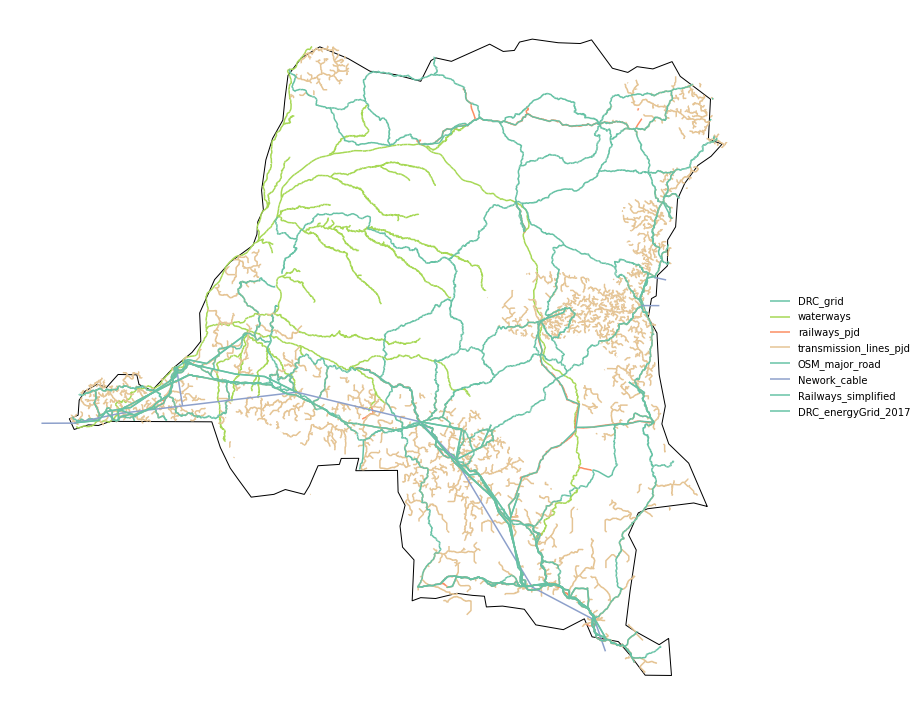

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
DRC_border.plot(ax=ax, color='white', edgecolor='black', figsize=(10, 10))
for ix, summary in polyline_layer_summaries.iterrows():
    # OSM_road_network*** layers are too big to be processd on a laptop
    # can't read africa_grid_20170906final_pjd with geopandas 0.6.3
    if ("OSM_road_network" in summary["layer_name"]) or (summary["layer_name"] == "africa_grid_20170906final_pjd"):
        continue
    gdf_layer = gpd.read_file("DRC_CPF/drc_cpf.gdb.zip", driver='FileGDB', layer=summary['layer_name'])
    gdf_layer.to_crs(epsg=4326).plot(ax=ax, label=summary['layer_name'], color=my_colors[ix%10])
# fig.suptitle('Polyline layers', fontsize=20)
lgd = ax.legend(frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
fig.tight_layout(pad=1)
plt.savefig(RESULT_DIR + 'vector_polyline_layers_DRC.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

## 3.2. Point layers (DRC)


In [12]:
point_layer_summaries = layer_summaries[layer_summaries['vector_shape_type'] == 'Point']
DRC_point_layer_summaries = point_layer_summaries[(point_layer_summaries['min_lon']>10) & (point_layer_summaries['max_lon']<33)]

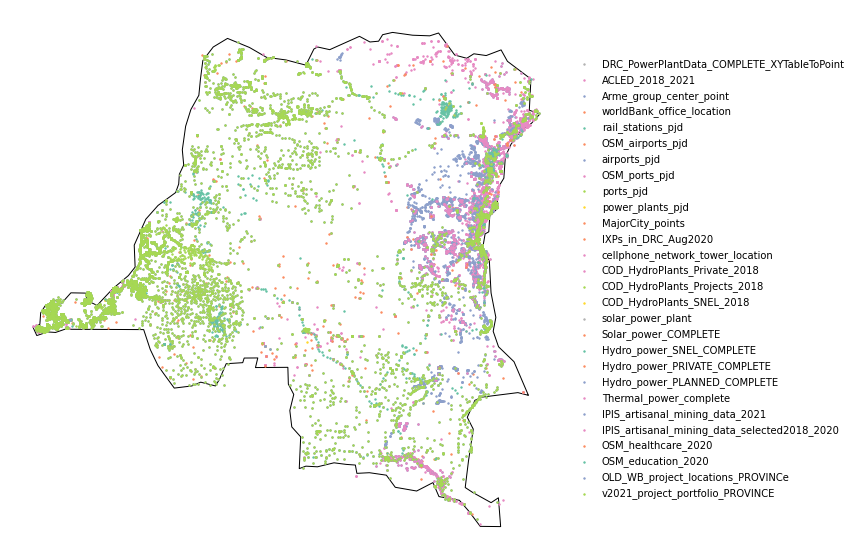

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
DRC_border.plot(ax=ax, color='white', edgecolor='black', figsize=(10, 10))
for ix, summary in DRC_point_layer_summaries.iterrows():
    # can't read COD_ThermalPlants_2017 with geopandas 0.6.3
    if (summary["layer_name"] == "COD_ThermalPlants_2017"):
        continue
    gdf_layer = gpd.read_file("DRC_CPF/drc_cpf.gdb.zip", driver='FileGDB', layer=summary['layer_name'])
    gdf_layer.to_crs(epsg=4326).plot(ax=ax, label=summary['layer_name'], color=my_colors[ix%10], markersize=2)
# fig.suptitle('Point layers (DRC)', fontsize=20)
lgd = ax.legend(frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.savefig(RESULT_DIR + 'vector_point_layers_DRC.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

## 3.3. Point layers (WLD)


In [14]:
WLD_point_layer_summaries = point_layer_summaries[(point_layer_summaries['min_lon']<10) | (point_layer_summaries['max_lon']>33)]

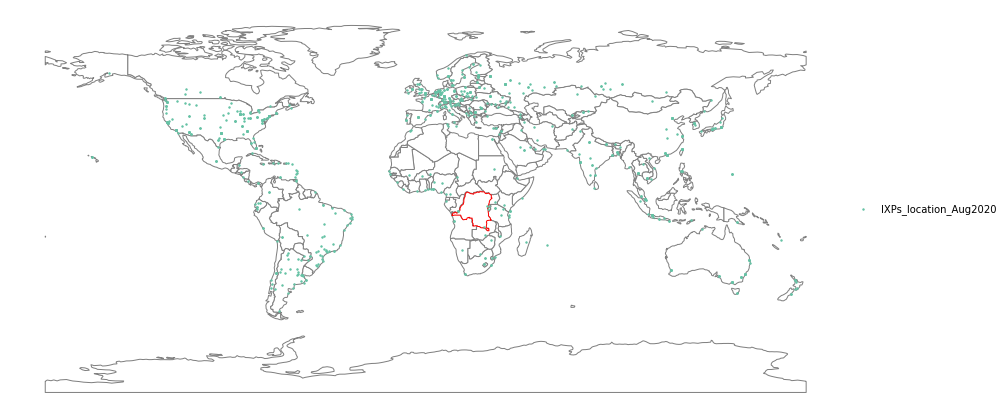

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
WLD_border.plot(ax=ax, color='white', edgecolor='gray', figsize=(10, 10))
DRC_border.plot(ax=ax, color='white', edgecolor='red', figsize=(10, 10))
for ix, summary in WLD_point_layer_summaries.iterrows():
    gdf_layer = gpd.read_file("DRC_CPF/drc_cpf.gdb.zip", driver='FileGDB', layer=summary['layer_name'])
    gdf_layer.to_crs(epsg=4326).plot(ax=ax, label=summary['layer_name'], color=my_colors[ix%10], markersize=2)
# fig.suptitle('Point layers (WLD)', fontsize=20)
lgd = ax.legend(frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.savefig(RESULT_DIR + 'vector_point_layers_WLD.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

## 3.4. Polygon layers (DRC)


In [16]:
polygon_layer_summaries = layer_summaries[layer_summaries['vector_shape_type'] == 'Polygon']
DRC_polygon_layer_summaries = polygon_layer_summaries[(polygon_layer_summaries['min_lon']>10) & (polygon_layer_summaries['max_lon']<33)]

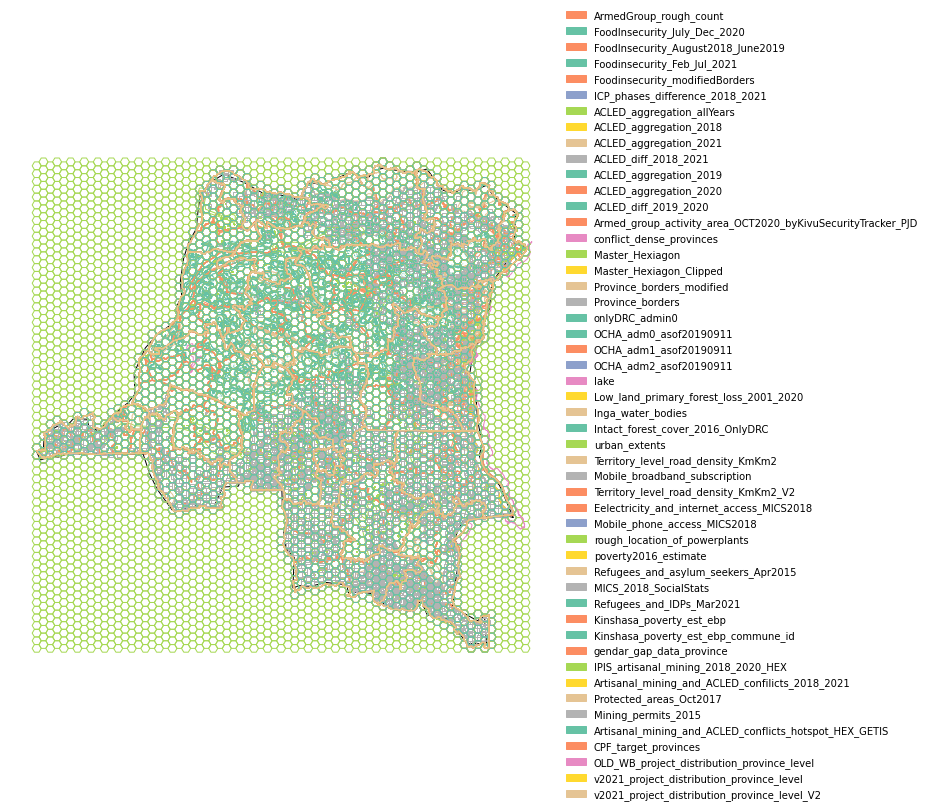

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
DRC_border.plot(ax=ax, color='white', edgecolor='black', figsize=(10, 10))
legend_patches = []
for ix, summary in DRC_polygon_layer_summaries.iterrows():
    gdf_layer = gpd.read_file("DRC_CPF/drc_cpf.gdb.zip", driver='FileGDB', layer=summary['layer_name'])
    gdf_layer.to_crs(epsg=4326).plot(ax=ax, label=summary['layer_name'], facecolor="none", edgecolor=my_colors[ix%10])
    # geopandas bug: Polygon handles do not passing to legend (https://github.com/geopandas/geopandas/issues/660)
    # add legends with dummy patches
    legend_patches.append(mpatches.Patch(color=my_colors[ix%10], label=summary['layer_name']))

# fig.suptitle('Polygon layers (DRC)', fontsize=20)
lgd = ax.legend(handles=legend_patches, frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.savefig(RESULT_DIR + 'vector_polygon_layers_DRC.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

## 3.5. Polygon layers (WLD)


In [18]:
WLD_Polygon_layer_summaries = polygon_layer_summaries[(polygon_layer_summaries['min_lon']<10) | (polygon_layer_summaries['max_lon']>33)]

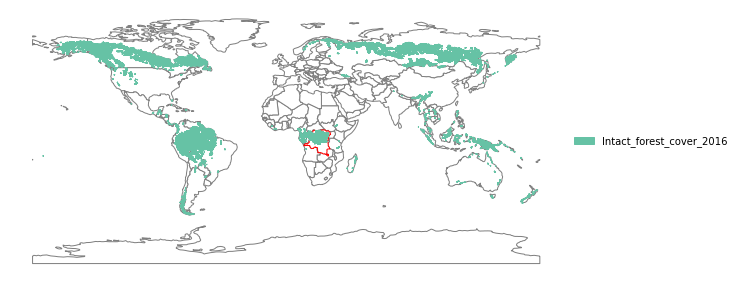

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
WLD_border.plot(ax=ax, color='white', edgecolor='gray', figsize=(10, 10))
DRC_border.plot(ax=ax, color='white', edgecolor='red', figsize=(10, 10))
legend_patches = []
for ix, summary in WLD_Polygon_layer_summaries.iterrows():
    gdf_layer = gpd.read_file("DRC_CPF/drc_cpf.gdb.zip", driver='FileGDB', layer=summary['layer_name'])
    gdf_layer.to_crs(epsg=4326).plot(ax=ax, label=summary['layer_name'], color=my_colors[0], edgecolor=my_colors[0], legend=True, legend_kwds=dict(frameon=False, loc=('center left'), title="LEGEND", fontsize=3, bbox_to_anchor=(1, 0.5)))
    # geopandas bug: Polygon handles not passing to legend (https://github.com/geopandas/geopandas/issues/660)
    # add legends with dummy patches
    legend_patches.append(mpatches.Patch(color=my_colors[0], label=summary['layer_name']))

# fig.suptitle('Polygon layers (WLD)', fontsize=20)
lgd = ax.legend(handles=legend_patches, frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.savefig(RESULT_DIR + 'vector_polygon_layers_WLD.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

## 3.6. Raster layers

In [20]:
raster_layer_summaries = layer_summaries[layer_summaries['data_type'] == 'RasterDataset']
raster_layer_summaries

,dir,layer_name,layer_label,description,data_type,crs_name,crs_code,num_dimensions,vector_shape_type,vector_object_count,raster_width,raster_height,table_num_rows,min_lon,max_lon,min_lat,max_lat,source_name,source_url,data_process_summary
7,,AFRICA_DRC_buildingDesnity_ALL,,,RasterDataset,GCS_WGS_1984,4326,1,,,2292,2261,,12.2071,31.3071,-13.4554,5.38625,,,
8,,WorldPop_2020_UNadjusted,,,RasterDataset,GCS_WGS_1984,4326,1,,,22918,22610,,12.2071,31.3054,-13.4554,5.38625,,,
9,,WorldPop_2020_UNadjusted_pjd,,,RasterDataset,WGS_1984_Web_Mercator_Auxiliary_Sphere,3857,1,,,22838,22690,,12.2071,31.306,-13.4555,5.38625,,,
11,,GSM_4G,,,RasterDataset,WGS_1984_Web_Mercator_Auxiliary_Sphere,3857,1,,,8042,7986,,12.1984,31.3136,-13.4563,5.3924,,,
12,,GSM_3G,,,RasterDataset,WGS_1984_Web_Mercator_Auxiliary_Sphere,3857,1,,,8042,7986,,12.1984,31.3136,-13.4563,5.3924,,,
13,,GSM_2G,,,RasterDataset,WGS_1984_Web_Mercator_Auxiliary_Sphere,3857,1,,,8042,7986,,12.1984,31.3136,-13.4563,5.3924,,,
16,,PVOUT_yearly_average_of_daily_totals,,,RasterDataset,GCS_WGS_1984,4326,1,,,2295,2263,,12.1917,31.3167,-13.4583,5.4,,,
17,,PVOUT_Clip1,,,RasterDataset,GCS_WGS_1984,4326,1,,,2295,2263,,12.1917,31.3167,-13.4583,5.4,,,
18,,PVOUT_Clip2,,,RasterDataset,GCS_WGS_1984,4326,1,,,2295,2263,,12.1917,31.3167,-13.4583,5.4,,,


### 3.6.1. AFRICA_DRC_buildingDesnity_ALL

In [21]:
raster_building_summary = raster_layer_summaries[raster_layer_summaries['layer_name'].str.contains("buildingDesnity")]

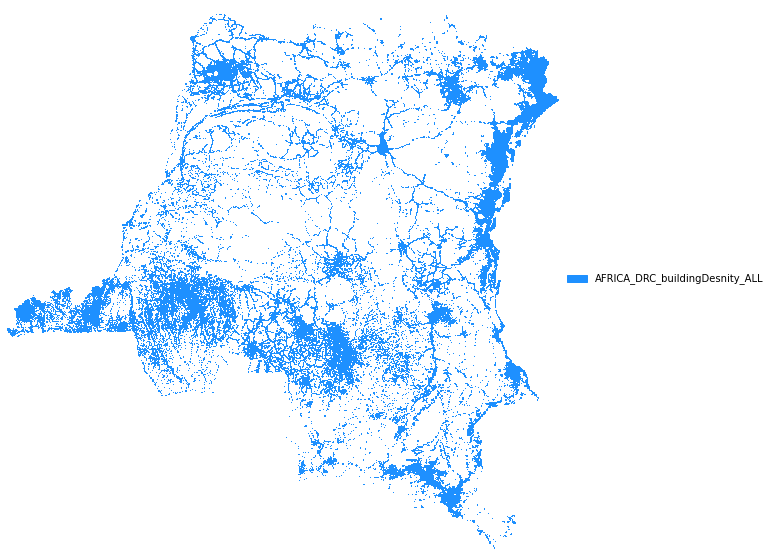

In [22]:
my_colors = ['dodgerblue']
fig, ax = plt.subplots(figsize=(10, 10))
legend_patches = []
for ix, summary in raster_building_summary.iterrows():
    array = arcpy.RasterToNumPyArray(arcpy.Raster("AFRICA_DRC_buildingDesnity_ALL"))
    mean = np.mean(array)
    std_range = np.std(array) * 1
    my_cmap = matplotlib.colors.ListedColormap(['none', my_colors[0]])    
    ax.set_axis_off()
    ax.imshow(array, cmap=my_cmap, vmin=mean-std_range, vmax=mean+std_range)
    legend_patches.append(mpatches.Patch(color=my_colors[0], label="AFRICA_DRC_buildingDesnity_ALL"))
lgd = ax.legend(handles=legend_patches, frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
plt.savefig(RESULT_DIR + 'raster_building_desnity_DRC.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)

### 3.6.2. GSM

In [23]:
raster_gsm_summary = raster_layer_summaries[raster_layer_summaries['layer_name'].str.contains("GSM")]

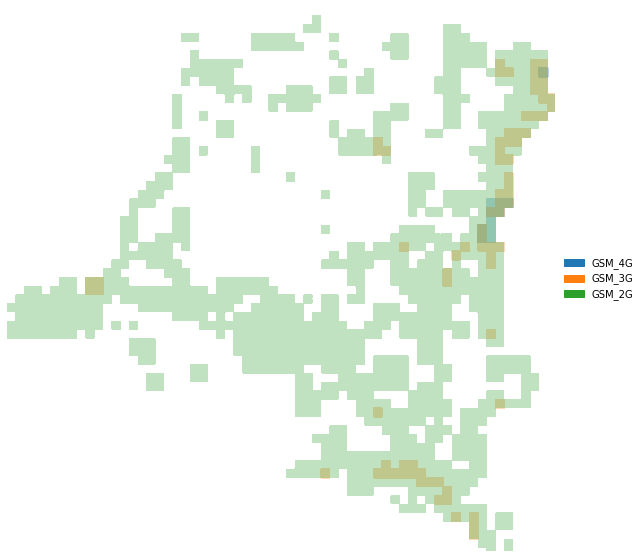

In [24]:
my_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:purple']
fig, ax = plt.subplots(figsize=(10, 10))
legend_patches = []
for ix, summary in raster_gsm_summary.iterrows():
    array = arcpy.RasterToNumPyArray(arcpy.Raster(summary["layer_name"]))
    mean = np.mean(array)
    std_range = np.std(array) * 1
    my_cmap = matplotlib.colors.ListedColormap(['none', my_colors[ix%3]])    
    ax.set_axis_off()
    ax.imshow(array, alpha=0.3, cmap=my_cmap, vmin=mean-std_range, vmax=mean+std_range)
    legend_patches.append(mpatches.Patch(color=my_colors[ix%3], label=summary["layer_name"]))
lgd = ax.legend(handles=legend_patches, frameon=False, loc=('center left'), bbox_to_anchor=(1, 0.5))
plt.savefig(RESULT_DIR + 'raster_GSM_DRC.jpg', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close(fig)